## Homework 2

In [44]:
from fredapi import Fred
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px

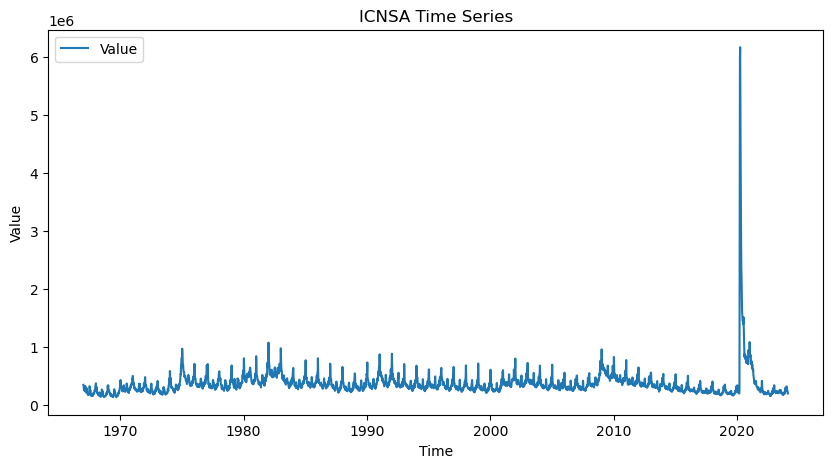

In [86]:
from fredapi import Fred
import plotly.express as px
import pandas as pd

api_key = "53b538f58efe93c97a8626e8559a0372"
fred = Fred(api_key=api_key)

series_id = "ICNSA"
data = fred.get_series(series_id)

icnsa_df = data.to_frame().reset_index()
icnsa_df.columns = ['time', 'I_value']


# Plotting the time series using Matplotlib
plt.figure(figsize=(10, 5)) 
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Value') 
plt.title(f"{series_id} Time Series")  
plt.xlabel('Time')
plt.ylabel('Value')  
plt.legend()  
plt.show()  


# Identification of covid start date and end date with empirical analysis

Visualized the Plot to observe any significant changes or spikes in the values that could indicate the onset of the COVID-19 pandemic impact.
-Start Date: March 2020. This is when many countries started to feel the significant impacts of COVID-19, with lockdowns leading to spikes in unemployment claims.

Identified key changes by looking for a sharp increase in initial claims as an indicator of the pandemic's start. Similarly, identified when these numbers began to decrease towards pre-pandemic levels, which could mark the end of the pandemic impact period.
-End Date:Around MAY 2021. By mid-2021, many places began to recover, and employment figures started to stabilize, although the exact timeline can vary by region.

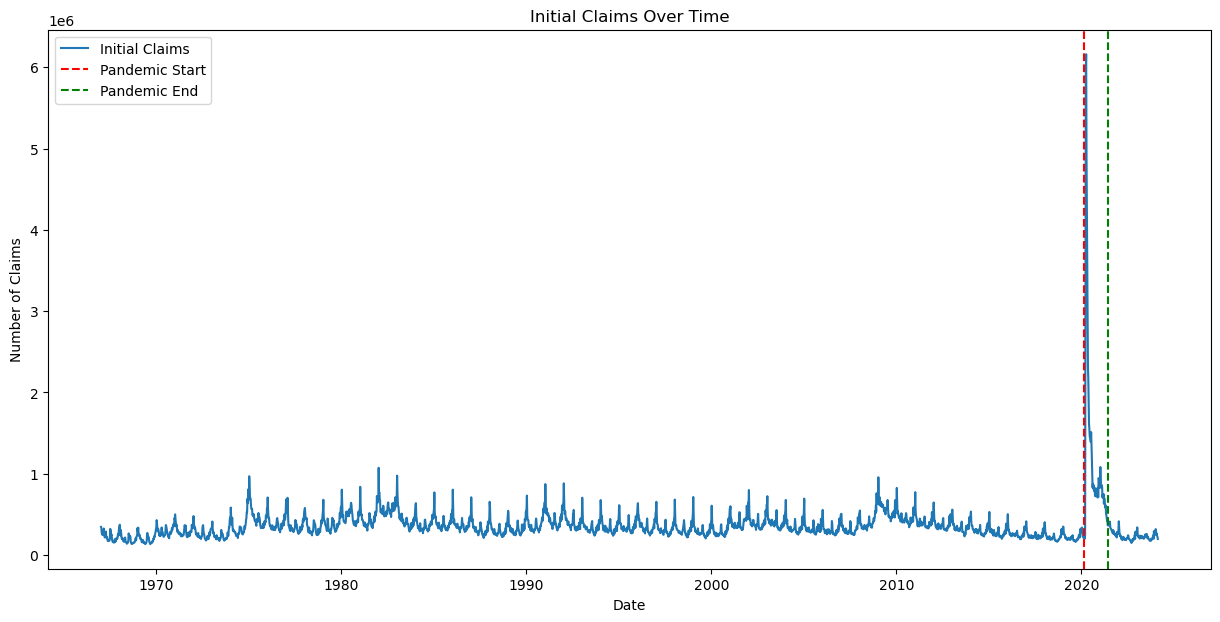

In [66]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Initial Claims')

plt.axvline(x=pd.Timestamp('2020-03-01'), color='r', linestyle='--', label='Pandemic Start')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='g', linestyle='--', label='Pandemic End')

plt.title('Initial Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.show()


### Using CubicSpline Method

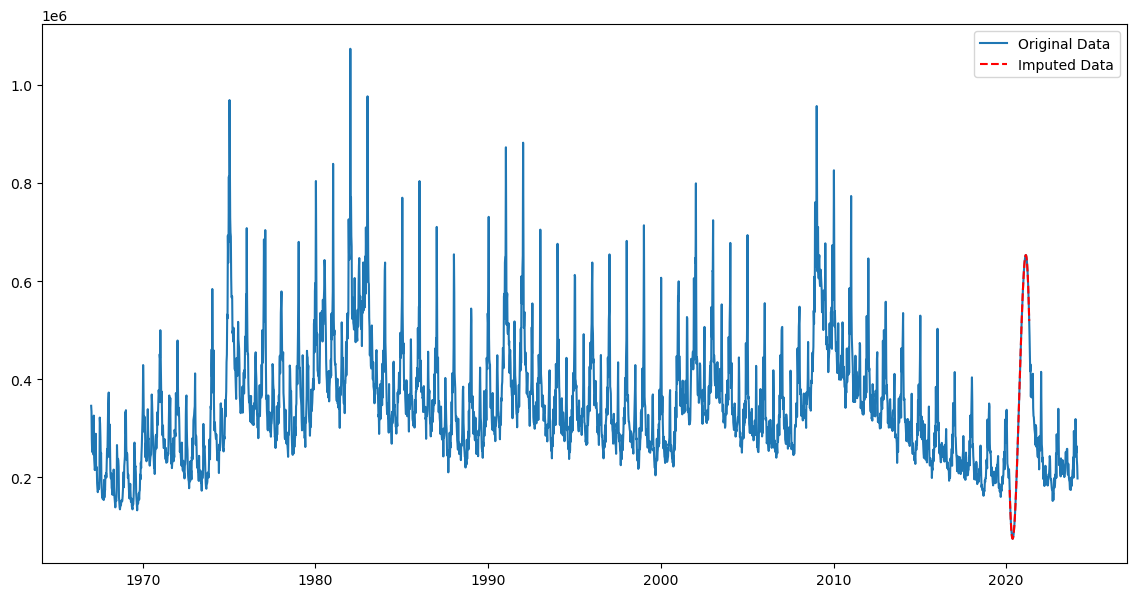

In [62]:
from scipy.interpolate import CubicSpline
start_index = icnsa_df[icnsa_df['time'] == '2020-03-14'].index[0]
end_index = icnsa_df[icnsa_df['time'] == '2021-05-01'].index[0]

# Fit cubic spline on data excluding the COVID period
cs = CubicSpline(icnsa_df.loc[~icnsa_df.index.isin(range(start_index, end_index + 1)), 'time'],
                 icnsa_df.loc[~icnsa_df.index.isin(range(start_index, end_index + 1)), 'I_value'])

icnsa_df.loc[start_index:end_index, 'I_value'] = cs(icnsa_df.loc[start_index:end_index, 'time'])

plt.figure(figsize=(14, 7))
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Original Data')
plt.plot(icnsa_df.loc[start_index:end_index, 'time'], imputed_values, label='Imputed Data', color='red', linestyle='--')
plt.legend()
plt.show()


### Using UnivariateSpline Method

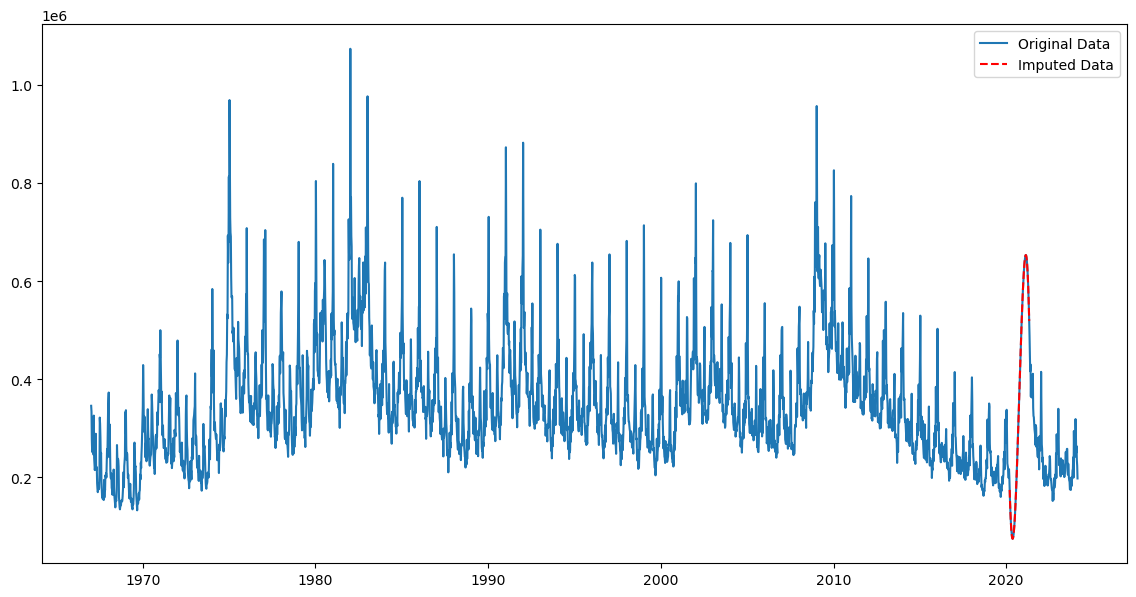

In [87]:
import pandas as pd

icnsa_df['time'] = pd.to_datetime(icnsa_df['time'])

icnsa_df['time_numeric'] = (icnsa_df['time'] - icnsa_df['time'].min()).dt.days
start_index = icnsa_df[icnsa_df['time'] == '2020-03-14'].index[0]
end_index = icnsa_df[icnsa_df['time'] == '2021-05-01'].index[0]


spline = UnivariateSpline(
    icnsa_df.loc[~icnsa_df.index.isin(range(start_index, end_index + 1)), 'time_numeric'],
    icnsa_df.loc[~icnsa_df.index.isin(range(start_index, end_index + 1)), 'I_value'], s=0.6
)

knots = spline.get_knots()
coeffs = spline.get_coeffs()
effective_dof = len(coeffs)

imputed_values = spline(icnsa_df.loc[start_index:end_index, 'time_numeric'])

icnsa_df.loc[start_index:end_index, 'I_value'] = imputed_values

plt.figure(figsize=(14, 7))
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Original Data')
plt.plot(icnsa_df.loc[start_index:end_index, 'time'], imputed_values, label='Imputed Data', color='red', linestyle='--')
plt.legend()
plt.show()

In [88]:
effective_dof = spline.get_residual()
print(knots, coeffs, effective_dof)

[0.0000e+00 1.4000e+01 2.1000e+01 ... 2.0839e+04 2.0846e+04 2.0860e+04] [346000.00001211 372305.84257197 279888.3155616  ... 206051.33492441
 236779.07786856 197932.00031772] 0.5999950426379882


According to the documentation, scipy.interpolate.CubicSpline function in python does not have a lambda argument. This is because the CubicSpline function in python uses a different method for fitting spline. It uses a method called “not-a-knot” to fit the spline. This method ensures that the spline is continuous at knots.

Instead, I used a UnivariateSpline function, which allows to control the smoothness of the spline in python. I tried using multiple values of s or λ here but not a lot of change in the forecasted values are to be seen, this could be due to multiple reasons such as : 

•	The spline naturally fits the data well even without additional smoothing. It means that the fit doesn't change much with variations in s due to the inherent stability of the spline with respect to the data.

•	UnivariateSpline estimates a good value for s by default, which aims to balance the fit and the smoothness. 


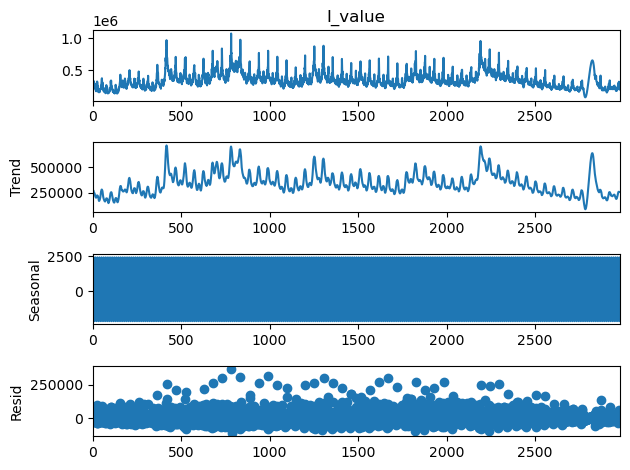

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(icnsa_df['I_value'], model='additive', period=12)
decompose_result.plot()
plt.show()




In [91]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# additive model
model_add = ExponentialSmoothing(icnsa_df['I_value'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_add = model_add.forecast(1)

# multiplicative model
model_mul = ExponentialSmoothing(icnsa_df['I_value'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
forecast_mul = model_mul.forecast(1)


C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [92]:
forecast_mul

2981    205855.81809
dtype: float64

In [94]:
model_mul.summary()

Dep. Variable:,I_value,No. Observations:,2981
Model:,ExponentialSmoothing,SSE,8095915828540.892
Optimized:,True,AIC,64786.375
Trend:,Multiplicative,BIC,64882.375
Seasonal:,Multiplicative,AICC,64786.606
Seasonal Periods:,12,Date:,"Mon, 26 Feb 2024"
Box-Cox:,False,Time:,18:50:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8182143,alpha,True
smoothing_trend,0.0001,beta,True


In [93]:
forecast_add

2981    199241.715134
dtype: float64

In [95]:
model_add.summary()

Dep. Variable:,I_value,No. Observations:,2981
Model:,ExponentialSmoothing,SSE,7970971492959.013
Optimized:,True,AIC,64740.011
Trend:,Additive,BIC,64836.011
Seasonal:,Additive,AICC,64740.242
Seasonal Periods:,12,Date:,"Mon, 26 Feb 2024"
Box-Cox:,False,Time:,18:50:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7828571,alpha,True
smoothing_trend,0.0001,beta,True


Considering the summary outputs:

The additive model has a slightly lower SSE compared to the multiplicative model, indicating it fits the data slightly better in terms of error minimization.

AIC and BIC: The values for both models are very similar, suggesting that there's not a significant difference in the fit quality between the two models according to these criteria.


Considering the trend and seasonality plots:

The trend component does not seem to increase, suggesting that an additive trend could be appropriate.

The seasonal component appears to be constant, which would also suggest an additive model.
